In [1]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import hdf5storage
import time
import h5py
from torch.utils.data import Dataset, DataLoader

from core import image_utils
from core import model_utils
from core import data_loader
from core import models_3D,models_seg

In [2]:
gpu_no = "0"
device = torch.device("cuda:"+str(gpu_no) if torch.cuda.is_available() else "cpu")
batch_size = 1
epochs = 100
lr = 1e-3
print_step = 20
num_workers = 6
lamda = 10e3

In [3]:
data_path = "/media/damingshen/05ba0687-eb77-48c2-a767-e9a44fbe94c1/Daming_data"
model_path = data_path + "/models"

train_path = data_path + "/Ashitha/test_data"
x_folder = "extracted_images"
x_fnames = os.listdir(train_path + "/" + x_folder)
x_files = [os.path.join(train_path, x_folder, fname) for fname in x_fnames]

In [4]:
mrinet = models_seg.Unet_seg3D_2Dpool(features=64,drop_out = 0.05,in_channel = 4, classes = 4, mode = "res").to(device)
model_name = "TPM_Seg_4LUNet_HD.pth"
mrinet.load(path = model_path, filename = model_name)

loaded: /media/damingshen/05ba0687-eb77-48c2-a767-e9a44fbe94c1/Daming_data/models/TPM_Seg_4LUNet_HD.pth


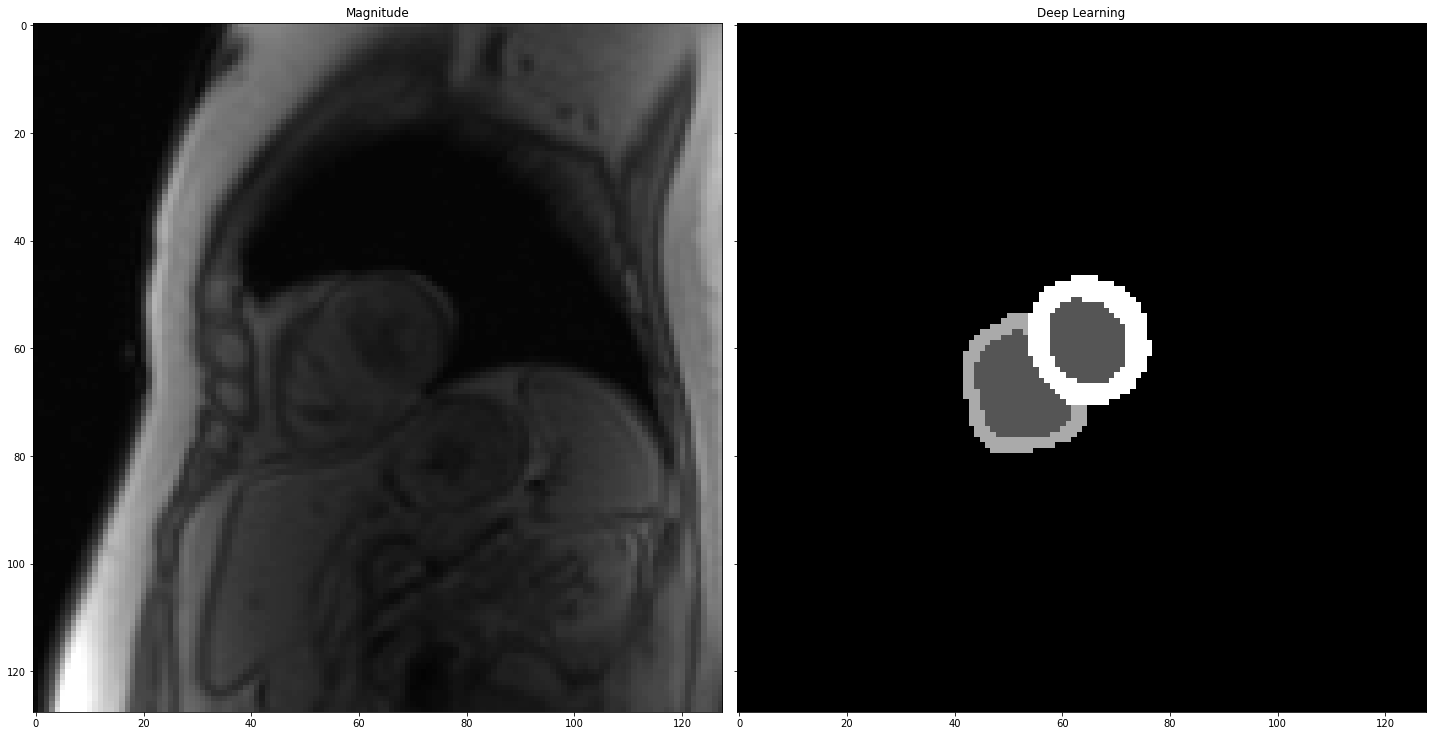

['/media/damingshen/05ba0687-eb77-48c2-a767-e9a44fbe94c1/Daming_data/Ashitha/test_data/extracted_images/205106-095_slice1_image.mat']


In [5]:
import random
idx = random.randint(0,len(x_fnames)-1)
# idx =25
dataset = data_loader.Loader3D_TPM_test(x_files[idx:idx+1], imsize = 128)
loader = DataLoader(dataset,
                 batch_size = 1,
                 shuffle = True,
                 drop_last = False,
                 num_workers = 1)

for batch_idx, data in enumerate(loader):
            x = data["x"].to(device)
            
mrinet.eval()   
out = mrinet(x)
out = torch.argmax(out,dim=1,keepdim =True)

# cy = y.data.cpu().numpy()
cx = x.data.cpu().numpy()
cout = out.data.cpu().numpy()

t_frame = 10
mag = cx[0,0,t_frame]*4
# vel = cx[0,1,t_frame]//5
DL = cout[0,0,t_frame]

vmin = 0
vmax= 3
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20,15))
ax[0].imshow(np.abs(mag), cmap = "gray", vmin = vmin, vmax = vmax)
# ax[1].imshow(np.abs(vel), cmap = "gray", vmin = vmin, vmax = vmax)
# ax[2].imshow(np.abs(mask), cmap = "gray", vmin = vmin, vmax = vmax)
ax[1].imshow(np.abs(DL), cmap = "gray", vmin = vmin, vmax = vmax)

ax[0].set_title("Magnitude")
# ax[1].set_title("Velocity")
# ax[2].set_title("Ref")
ax[1].set_title("Deep Learning")

fig.tight_layout()
plt.show()
print(x_files[idx:idx+1])

In [6]:
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')
DL_folder = "SegDL"
x_suffix="image.mat"
DL_suffix="SegDL.mat"
for idx in range(len(x_files)):
    dataset = data_loader.Loader3D_TPM_test(x_files[idx:idx+1], imsize = 128)
    loader = DataLoader(dataset,
                 batch_size = 1,
                 shuffle = False,
                 drop_last = False,
                 num_workers = 6)
    for batch_idx, data in enumerate(loader):
        x = data["x"].to(device)
#         y = data["y"].to(device)
    mrinet.eval()   
    out = mrinet(x)
    out = torch.argmax(out,dim=1,keepdim =True)
    cout = out.data.cpu().numpy()
    cout = cout[0,0] 
    
    SegDL = np.squeeze(cout)
    
    x_file = x_files[idx]
    DL_file = x_file.replace(x_folder,DL_folder)
    DL_file = DL_file.replace(x_suffix,DL_suffix)
    hdf5storage.savemat(DL_file, dict(SegDL = SegDL))
#     print(DL_file)
    logging.info(x_fnames[idx])

2020-09-18 14:26:31,270 205106-086_slice2_image.mat
2020-09-18 14:26:32,214 205106-081_slice1_image.mat
2020-09-18 14:26:33,134 205106-084_slice3_image.mat
2020-09-18 14:26:34,084 205106-084_slice1_image.mat
2020-09-18 14:26:35,031 205106-081_slice2_image.mat
2020-09-18 14:26:36,150 205106-095_slice2_image.mat
2020-09-18 14:26:37,194 205106-095_slice1_image.mat
2020-09-18 14:26:38,109 205106-084_slice2_image.mat
2020-09-18 14:26:38,989 205106-083_slice1_image.mat
2020-09-18 14:26:39,978 205106-070_slice2_image.mat
2020-09-18 14:26:40,947 205106-070_slice1_image.mat
2020-09-18 14:26:41,741 205106-090_slice1_image.mat
2020-09-18 14:26:42,524 205106-090_slice3_image.mat
2020-09-18 14:26:43,283 205106-090_slice2_image.mat
2020-09-18 14:26:44,369 205106-095_slice3_image.mat
2020-09-18 14:26:45,214 205106-086_slice1_image.mat
2020-09-18 14:26:46,161 205106-081_slice3_image.mat
2020-09-18 14:26:47,102 205106-083_slice3_image.mat
2020-09-18 14:26:48,062 205106-070_slice3_image.mat
2020-09-18 1